In [2]:
print("hello")

hello


In [3]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x1= self.conv(x) 
        return F.sigmoid(x1)
        

In [0]:

import torch.nn.functional as F



class UNet(nn.Module):
    def __init__(self, bilinear=True):
        super(UNet, self).__init__()
        self.bilinear = bilinear

        self.inc = DoubleConv(3, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 512)
        self.up1 = Up(1024, 256, bilinear)
        self.up2 = Up(512, 128, bilinear)
        self.up3 = Up(256, 64, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, 3)
        

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [0]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models


import os

class Pick_images(Dataset):
    def __init__(self,data_dir, transform=None):
        self.input_images = datasets.ImageFolder(os.path.join(data_dir,"imgs"))
        self.target_masks = datasets.ImageFolder(os.path.join(data_dir,"masks"))     
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):  
        image = self.input_images[idx][0]

        mask = self.target_masks[idx][0]
        if self.transform:
            # image = transforms.Compose([ transforms.CenterCrop((300,200)),])
            image=transforms.Compose([transforms.CenterCrop((300,200)),transforms.ToTensor(),])(image)
            mask = self.transform(mask)



        
        return image, mask


In [58]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
trans = transforms.Compose([
   transforms.CenterCrop((300,200)), transforms.ToTensor(),normalize
])

data_train='/content/drive/My Drive/MAP583/dataset/train'
data_valid='/content/drive/My Drive/MAP583/dataset/valid'
train_set = Pick_images(data_train,transform = trans)
val_set = Pick_images(data_valid,transform = trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 5

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 40, 'val': 20}

In [0]:
import torch
import torch.nn as nn


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [55]:
print(device)

cuda


In [0]:
for images, masks in dataloaders["train"]:
                images = images.to(device)
                masks = masks.to(device)  
                break;    

In [34]:
images.size()

torch.Size([5, 3, 300, 200])

In [0]:
model = UNet()
model = model.to(device)

In [0]:
import torch.nn as nn



def train_model(model, optimizer, scheduler, criterion ,num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    losses=[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

                epoch_samples = 0
            
            for images, masks in dataloaders[phase]:
                images = images.to(device)
                masks = masks.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(masks)
                    loss=criterion(outputs,images)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples = images.size(0)

            epoch_loss = loss / epoch_samples

            # deep copy the model
            if phase == 'val':  
                losses.append(epoch_loss)
            if phase == 'val' and epoch_loss < best_loss:
                losses.append(epoch_loss)
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,losses

In [68]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
criterion = nn.L1Loss()
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr=1e-4) ### Decay

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=25, gamma=0.1)

model ,losses = train_model(model, optimizer_ft, exp_lr_scheduler,criterion, num_epochs=50)

Epoch 0/49
----------
LR 0.0001


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


saving best model
0m 3s
Epoch 1/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 2/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 3/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 4/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 5/49
----------
LR 0.0001
0m 3s
Epoch 6/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 7/49
----------
LR 0.0001
0m 3s
Epoch 8/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 9/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 10/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 11/49
----------
LR 0.0001
0m 3s
Epoch 12/49
----------
LR 0.0001
0m 3s
Epoch 13/49
----------
LR 0.0001
0m 3s
Epoch 14/49
----------
LR 0.0001
0m 3s
Epoch 15/49
----------
LR 0.0001
0m 3s
Epoch 16/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 17/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 18/49
----------
LR 0.0001
saving best model
0m 3s
Epoch 19/49
----------
LR 0.0001
0m 3s
Epoch 20/49
----------
LR 0.0001
saving best m

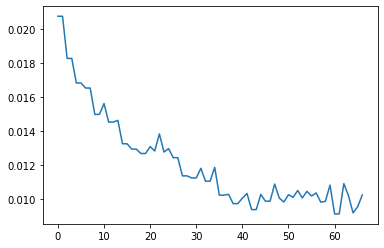

In [72]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(losses)),losses)

In [73]:
model.eval()   # Set model to evaluate mode
data_test="/content/drive/My Drive/MAP583/dataset/test"
test_dataset = Pick_images(data_train,transform = trans)
test_loader = DataLoader(test_dataset, batch_size=5, shuffle=False, num_workers=0)
        
inputs,masks = next(iter(test_loader))
inputs = inputs.to(device)
masks = masks.to(device)

pred = model(inputs)



/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


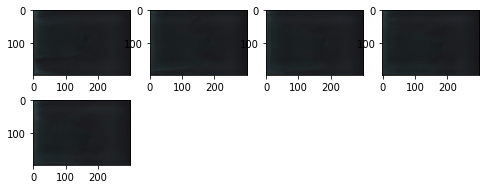

In [79]:
# for tensor_1 in pred :
#     tensor_1=tensor_1.permute(2, 1, 0) 
#     plt.imshow(tensor_1.cpu().detach().numpy())



w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
i=0
for tensor_1 in pred:
    i+=1
    tensor_1=tensor_1.permute(2, 1, 0) 

    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.imshow(tensor_1.cpu().detach().numpy())
plt.show() 

In [0]:

for tensor_1 in pred:
  a=tensor_1

tensor([[[0.3868, 0.4390, 0.4348,  ..., 0.3218, 0.3365, 0.3775],
         [0.3514, 0.3498, 0.3775,  ..., 0.2657, 0.2460, 0.2769],
         [0.3070, 0.2583, 0.2833,  ..., 0.1684, 0.1728, 0.2351],
         ...,
         [0.1594, 0.1023, 0.1031,  ..., 0.1012, 0.1055, 0.1492],
         [0.1610, 0.1084, 0.1018,  ..., 0.1011, 0.1118, 0.1487],
         [0.2339, 0.1678, 0.1637,  ..., 0.1536, 0.1618, 0.1825]],

        [[0.4355, 0.4592, 0.4569,  ..., 0.3516, 0.3686, 0.3563],
         [0.4049, 0.3967, 0.4091,  ..., 0.2491, 0.2716, 0.2854],
         [0.3276, 0.3091, 0.3139,  ..., 0.2164, 0.2165, 0.2437],
         ...,
         [0.1477, 0.0981, 0.0919,  ..., 0.0898, 0.1018, 0.1441],
         [0.1660, 0.1075, 0.0969,  ..., 0.0959, 0.1126, 0.1565],
         [0.2161, 0.1786, 0.1746,  ..., 0.1732, 0.1854, 0.2441]],

        [[0.4433, 0.4843, 0.5051,  ..., 0.3623, 0.3762, 0.3810],
         [0.3831, 0.3829, 0.4007,  ..., 0.2576, 0.2541, 0.2939],
         [0.3473, 0.2904, 0.3151,  ..., 0.2131, 0.2007, 0.

In [0]:

a=torch.tensor(np.random.rand(6,5,3))


In [0]:
plt.imshow(pred_np.detach().numpy())